# Madrid  data cleaning and preparation

## Introduction

## 1. Download and explore de dataset

Train stations data: 'https://datos.madrid.es/egob/catalogo/200073-1-puntos-transporte-navegadores.gpx'
    
Metro stations data: 'https://datos.madrid.es/egob/catalogo/200073-12-puntos-transporte-navegadores.gpx'

In [1]:
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
import requests

### Train data

In [2]:

file = 'Cercanias_2019_12.xml'

xtree = et.parse(file)
xroot = xtree.getroot()

In [3]:
train_stations = pd.DataFrame(columns = ['tStation','Latitude','Longitude'])

i = 0
for node in xroot:
    if i != 0:
        latitude = node.attrib.get("lat")
        longitude = node.attrib.get("lon")
        name = node[0].text
        train_stations = train_stations.append({'tStation':name,'Latitude':latitude,'Longitude':longitude},ignore_index=True)
        #print('{}, lat: {}, lon: {}'.format(name,latitude,longitude))
    i = i+1
    
train_stations = train_stations.reset_index(drop=True)

In [4]:
train_stations.head()

tStation            Latitude            Longitude
0      C-1 AEROPUERTO T4   40.49176762416515   -3.593336761776833
1             C-1 ATOCHA   40.40658651228024  -3.6893092868843853
2          C-1 CHAMARTIN   40.47209555413991  -3.6824760485471546
3           C-1 DELICIAS  40.400367595318635  -3.6927692985734324
4  C-1 FUENTE DE LA MORA    40.4847413558896   -3.662829237134829

In [5]:
#We can get the line from the first column

train_stations['line'] = train_stations['tStation'].str.split(' ',n = 1, expand = True)[0]
train_stations['station'] = train_stations['tStation'].str.split(' ',n = 1, expand = True)[1]

In [6]:
train_stations = train_stations[['station', 'line', 'Latitude', 'Longitude']]
train_stations.head()

station line            Latitude            Longitude
0      AEROPUERTO T4  C-1   40.49176762416515   -3.593336761776833
1             ATOCHA  C-1   40.40658651228024  -3.6893092868843853
2          CHAMARTIN  C-1   40.47209555413991  -3.6824760485471546
3           DELICIAS  C-1  40.400367595318635  -3.6927692985734324
4  FUENTE DE LA MORA  C-1    40.4847413558896   -3.662829237134829

### Metro Data

In [7]:
file = 'Metro_2019_12.xml'

xtree = et.parse(file)
xroot = xtree.getroot()

In [8]:
metro_stations = pd.DataFrame(columns = ['mStation','Latitude','Longitude'])

i = 0
for node in xroot:
    if i != 0:
        latitude = node.attrib.get("lat")
        longitude = node.attrib.get("lon")
        name = node[0].text
        metro_stations = metro_stations.append({'mStation':name,'Latitude':latitude,'Longitude':longitude},ignore_index=True)
        #print('{}, lat: {}, lon: {}'.format(name,latitude,longitude))
    i = i+1
    
metro_stations = metro_stations.reset_index(drop=True)

#We can get the line from the first column

metro_stations['line'] = metro_stations['mStation'].str.split(' ',n = 1, expand = True)[0]
metro_stations['station'] = metro_stations['mStation'].str.split(' ',n = 1, expand = True)[1]

In [9]:
metro_stations = metro_stations[['station', 'line', 'Latitude', 'Longitude']]
metro_stations.head()

station line            Latitude            Longitude
0  ALTO DEL ARENAL    1  40.389768700352434  -3.6452252835565764
1         ALVARADO    1   40.45033105413335  -3.7033178070796913
2     ANTON MARTIN    1   40.41246302818812  -3.6993757416732405
3           ATOCHA    1  40.408846792956474   -3.692490883566612
4     ATOCHA RENFE    1  40.406586090726144   -3.689379993715528

Save the data

In [182]:
train_stations.to_csv('train_stations.csv')
metro_stations.to_csv('metro_stations.csv')

### Madrid Neighborhood shapefiles

link: https://datos.madrid.es/egob/catalogo/200078-10-distritos-barrios.zip

In [11]:
import geopandas as gp

In [12]:
neighboorhoods = gp.read_file('BARRIOS_ETRS89/SHP_ETRS89/BARRIOS.shp')

In [13]:
neighboorhoods.head()

OBJECTID  geodb_oid CODDIS      NOMDIS CODBAR CODDISTRIT CODBARRIO  \
0       108        108     17  Villaverde    172         17      17-2   
1       109        109     17  Villaverde    173         17      17-3   
2       111        111     17  Villaverde    175         17      17-5   
3       110        110     17  Villaverde    174         17      17-4   
4       107        107     17  Villaverde    171         17      17-1   

                                           NOMBRE  ORIG_FID  \
0                                   San Cristobal       107   
1                                        Butarque       108   
2                                     Los Angeles       110   
3                                     Los Rosales       109   
4  Villaverde Alto, Casco Histórico de Villaverde       106   

                                            geometry  
0  POLYGON ((441930.8668000005 4466853.1887, 4419...  
1  POLYGON ((444144.8566044134 4464473.210504748,...  
2  POLYGON ((441147.7280000008 4466374.483400001,...  
3  POLYGON ((442098.8264462068 4468081.978228984,...  
4  POLYGON ((440129.2758234279 4468362.077814397,...

In [14]:
neighboorhoods.shape

(131, 10)

In [15]:
import pyepsg

pyepsg.get(neighboorhoods.crs['init'].split(':')[1])


<ProjectedCRS: 25830, ETRS89 / UTM zone 30N>

In [16]:
neigh_json = neighboorhoods.to_crs(epsg='25830').to_json()
metro_stations = metro_stations.astype({'Latitude':'float32','Longitude':'float32'})

In [17]:
import folium

mapa = folium.Map([metro_stations['Latitude'].mean(), metro_stations['Longitude'].mean()],
                  zoom_start=11)

folium.GeoJson(
    neighboorhoods,
    style_function=lambda feature: {
        #'fillColor': 'green' if 'l' in feature['properties']['NOMBRE'].lower() else '#ffff00',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.1
    }
).add_to(mapa)

for lat, lon, poi, line in zip(metro_stations['Latitude'], 
                                  metro_stations['Longitude'], 
                                  metro_stations['station'], 
                                  metro_stations['line']):
    label = folium.Popup(str(poi) + ' Line ' + str(line), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(mapa)

mapa

# Population

In [18]:
poblacion = pd.read_excel('madrid_pop.xls', header = 4).dropna()

In [19]:
print(poblacion.shape)
poblacion

(131, 3)


Distrito                                          Barrio  \
0                 CENTRO                                         PALACIO   
1                 CENTRO                                     EMBAJADORES   
2                 CENTRO                                          CORTES   
3                 CENTRO                                        JUSTICIA   
4                 CENTRO                                     UNIVERSIDAD   
5                 CENTRO                                             SOL   
6             ARGANZUELA                                        IMPERIAL   
7             ARGANZUELA                                         ACACIAS   
8             ARGANZUELA                                         CHOPERA   
9             ARGANZUELA                                         LEGAZPI   
10            ARGANZUELA                                        DELICIAS   
11            ARGANZUELA                                 PALOS DE MOGUER   
12            ARGANZUELA                                          ATOCHA   
13                RETIRO                                        PACIFICO   
14                RETIRO                                         ADELFAS   
15                RETIRO                                        ESTRELLA   
16                RETIRO                                           IBIZA   
17                RETIRO                                       Jerónimos   
18                RETIRO                                      NIÑO JESUS   
19             SALAMANCA                                       RECOLETOS   
20             SALAMANCA                                            GOYA   
21             SALAMANCA                                FUENTE DEL BERRO   
22             SALAMANCA                                      GUINDALERA   
23             SALAMANCA                                           LISTA   
24             SALAMANCA                                      CASTELLANA   
25             CHAMARTIN                                         EL VISO   
26             CHAMARTIN                                     PROSPERIDAD   
27             CHAMARTIN                                   CIUDAD JARDIN   
28             CHAMARTIN                                  HISPANOAMERICA   
29             CHAMARTIN                                    NUEVA ESPAÑA   
..                   ...                                             ...   
101            HORTALEZA                                         PIOVERA   
102            HORTALEZA                                        CANILLAS   
103            HORTALEZA                                   PINAR DEL REY   
104            HORTALEZA                                APOSTOL SANTIAGO   
105            HORTALEZA                                    VALDEFUENTES   
106           VILLAVERDE  Villaverde Alto, Casco Histórico de Villaverde   
107           VILLAVERDE                                   SAN CRISTOBAL   
108           VILLAVERDE                                        BUTARQUE   
109           VILLAVERDE                                     LOS ROSALES   
110           VILLAVERDE                                     LOS ANGELES   
111    VILLA DE VALLECAS                     Casco Histórico de Vallecas   
112    VILLA DE VALLECAS                                   SANTA EUGENIA   
113    VILLA DE VALLECAS                            ENSANCHE DE VALLECAS   
114            VICALVARO                    Casco histórico de Vicálvaro   
115            VICALVARO                                   VALDEBERNARDO   
116            VICALVARO                                     VALDERRIVAS   
117            VICALVARO                                    EL CAÑAVERAL   
118  SAN BLAS-CANILLEJAS                                        SIMANCAS   
119  SAN BLAS-CANILLEJAS                                          HELLIN   
120  SAN BLAS-CANILLEJAS                                         AMPOSTA   
121  SAN BLAS-CANILLEJAS                                        

In [20]:
print(neighboorhoods.shape)
neighboorhoods

(131, 10)


OBJECTID  geodb_oid CODDIS                 NOMDIS CODBAR CODDISTRIT  \
0         108        108     17             Villaverde    172         17   
1         109        109     17             Villaverde    173         17   
2         111        111     17             Villaverde    175         17   
3         110        110     17             Villaverde    174         17   
4         107        107     17             Villaverde    171         17   
5          73         73     12                  Usera    121         12   
6         112        112     18      Villa de Vallecas    183         18   
7          71         71     11            Carabanchel    116         11   
8          64         64     10                 Latina    106         10   
9          75         75     12                  Usera    123         12   
10        112        112     18      Villa de Vallecas    181         18   
11         74         74     12                  Usera    122         12   
12         78         78     12                  Usera    126         12   
13         79         79     12                  Usera    127         12   
14         72         72     11            Carabanchel    117         11   
15         70         70     11            Carabanchel    115         11   
16         76         76     12                  Usera    124         12   
17        113        113     18      Villa de Vallecas    182         18   
18         69         69     11            Carabanchel    114         11   
19         80         80     13     Puente de Vallecas    131         13   
20         65         65     10                 Latina    107         10   
21         83         83     13     Puente de Vallecas    134         13   
22         82         82     13     Puente de Vallecas    133         13   
23         10         10     02             Arganzuela    024         02   
24         77         77     12                  Usera    125         12   
25         67         67     11            Carabanchel    112         11   
26         81         81     13     Puente de Vallecas    132         13   
27         84         84     13     Puente de Vallecas    135         13   
28         66         66     11            Carabanchel    111         11   
29         63         63     10                 Latina    105         10   
..        ...        ...    ...                    ...    ...        ...   
101        34         34     06                 Tetuán    063         06   
102        58         58     09      Moncloa - Aravaca    097         09   
103        99         99     15          Ciudad Lineal    158         15   
104        30         30     05              Chamartín    055         05   
105       103        103     16              Hortaleza    163         16   
106       128        128     21                Barajas    215         21   
107        55         55     09      Moncloa - Aravaca    094         09   
108        36         36     06                 Tetuán    065         06   
109        35         35     06                 Tetuán    064         06   
110        56         56     09      Moncloa - Aravaca    095         09   
111       126        126     21                Barajas    213         21   
112        54         54     09      Moncloa - Aravaca    093         09   
113        57         57     09      Moncloa - Aravaca    096         09   
114       104        104     16              Hortaleza    164         16   
115       105        105     16              Hortaleza    165         16   
116        31         31     05              Chamartín    056         05   
117       100        100     15          Ciudad Lineal    159         15   
118        47         47     08  Fuencarral - El Pardo    084         08   
119        46         46     08  Fuencarral - El Pardo    083         08   
120        48         48     08  Fuencarral - El Pardo    085         08   
121        45         45     08  Fuencarral - El Pard

In [21]:
neighboorhoods['low_name'] = neighboorhoods['NOMBRE'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()
neighboorhoods

OBJECTID  geodb_oid CODDIS                 NOMDIS CODBAR CODDISTRIT  \
0         108        108     17             Villaverde    172         17   
1         109        109     17             Villaverde    173         17   
2         111        111     17             Villaverde    175         17   
3         110        110     17             Villaverde    174         17   
4         107        107     17             Villaverde    171         17   
5          73         73     12                  Usera    121         12   
6         112        112     18      Villa de Vallecas    183         18   
7          71         71     11            Carabanchel    116         11   
8          64         64     10                 Latina    106         10   
9          75         75     12                  Usera    123         12   
10        112        112     18      Villa de Vallecas    181         18   
11         74         74     12                  Usera    122         12   
12         78         78     12                  Usera    126         12   
13         79         79     12                  Usera    127         12   
14         72         72     11            Carabanchel    117         11   
15         70         70     11            Carabanchel    115         11   
16         76         76     12                  Usera    124         12   
17        113        113     18      Villa de Vallecas    182         18   
18         69         69     11            Carabanchel    114         11   
19         80         80     13     Puente de Vallecas    131         13   
20         65         65     10                 Latina    107         10   
21         83         83     13     Puente de Vallecas    134         13   
22         82         82     13     Puente de Vallecas    133         13   
23         10         10     02             Arganzuela    024         02   
24         77         77     12                  Usera    125         12   
25         67         67     11            Carabanchel    112         11   
26         81         81     13     Puente de Vallecas    132         13   
27         84         84     13     Puente de Vallecas    135         13   
28         66         66     11            Carabanchel    111         11   
29         63         63     10                 Latina    105         10   
..        ...        ...    ...                    ...    ...        ...   
101        34         34     06                 Tetuán    063         06   
102        58         58     09      Moncloa - Aravaca    097         09   
103        99         99     15          Ciudad Lineal    158         15   
104        30         30     05              Chamartín    055         05   
105       103        103     16              Hortaleza    163         16   
106       128        128     21                Barajas    215         21   
107        55         55     09      Moncloa - Aravaca    094         09   
108        36         36     06                 Tetuán    065         06   
109        35         35     06                 Tetuán    064         06   
110        56         56     09      Moncloa - Aravaca    095         09   
111       126        126     21                Barajas    213         21   
112        54         54     09      Moncloa - Aravaca    093         09   
113        57         57     09      Moncloa - Aravaca    096         09   
114       104        104     16              Hortaleza    164         16   
115       105        105     16              Hortaleza    165         16   
116        31         31     05              Chamartín    056         05   
117       100        100     15          Ciudad Lineal    159         15   
118        47         47     08  Fuencarral - El Pardo    084         08   
119        46         46     08  Fuencarral - El Pardo    083         08   
120        48         48     08  Fuencarral - El Pardo    085         08   
121        45         45     08  Fuencarral - El Pard

In [22]:
poblacion['low_name'] = poblacion['Barrio'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()

In [23]:
neigh = gp.GeoDataFrame(pd.merge(neighboorhoods[['NOMBRE','low_name','geometry']],
                                 poblacion, 
                                 left_on='low_name', 
                                 right_on='low_name').rename(columns={'Total':'population'}),
                       geometry='geometry',
                       crs='EPSG:25830')

In [24]:
print(neigh.shape)
neigh.head()

(131, 6)


NOMBRE  \
0                                   San Cristobal   
1                                        Butarque   
2                                     Los Angeles   
3                                     Los Rosales   
4  Villaverde Alto, Casco Histórico de Villaverde   

                                         low_name  \
0                                   san cristobal   
1                                        butarque   
2                                     los angeles   
3                                     los rosales   
4  villaverde alto, casco historico de villaverde   

                                            geometry    Distrito  \
0  POLYGON ((441930.8668000005 4466853.1887, 4419...  VILLAVERDE   
1  POLYGON ((444144.8566044134 4464473.210504748,...  VILLAVERDE   
2  POLYGON ((441147.7280000008 4466374.483400001,...  VILLAVERDE   
3  POLYGON ((442098.8264462068 4468081.978228984,...  VILLAVERDE   
4  POLYGON ((440129.2758234279 4468362.077814397,...  VILLAVERDE   

                                           Barrio  population  
0                                   SAN CRISTOBAL     16969.0  
1                                        BUTARQUE     20180.0  
2                                     LOS ANGELES     32785.0  
3                                     LOS ROSALES     38282.0  
4  Villaverde Alto, Casco Histórico de Villaverde     46991.0

In [25]:
neigh['density'] = neigh['population'] / (neigh.area/1000)

In [26]:
import folium

mapi = folium.Map([metro_stations['Latitude'].mean(), metro_stations['Longitude'].mean()],
                  zoom_start=11)

folium.TileLayer('cartodbpositron', attr='igs').add_to(mapi)

choropleth = folium.Choropleth(
    geo_data=neigh,
    data=neigh[['low_name','density']],
    columns=['low_name','density'],
    key_on='feature.properties.low_name',
    fill_color='YlGn',
    fillOpacity= 0.1,
    legend_name='density (inhabitats per square km)',
    highlight=True
).add_to(mapi)

for lat, lon, poi, line in zip(metro_stations['Latitude'], 
                                  metro_stations['Longitude'], 
                                  metro_stations['station'], 
                                  metro_stations['line']):
    label = folium.Popup(str(poi) + ' Line ' + str(line), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(mapi)


choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['density','Barrio'])
)


mapi

In [27]:
barrios_funcionan = neigh['low_name'].tolist()
perro =  poblacion[~poblacion['low_name'].isin(barrios_funcionan)]

perro2 = neighboorhoods[~neighboorhoods['low_name'].isin(barrios_funcionan)]

In [28]:
perro

Empty DataFrame
Columns: [Distrito, Barrio, Total, low_name]
Index: []

In [29]:
perro2

Empty GeoDataFrame
Columns: [OBJECTID, geodb_oid, CODDIS, NOMDIS, CODBAR, CODDISTRIT, CODBARRIO, NOMBRE, ORIG_FID, geometry, low_name]
Index: []

# Gyms

In [173]:
gyms = pd.DataFrame([{'name':'place1', 'lat':40.433487, 'lon':-3.645917},
                     {'name':'place2', 'lat':40.400732, 'lon':-3.665297},
                     {'name':'place3', 'lat':40.446905, 'lon':-3.674936},
                     ])
gyms

lat       lon    name
0  40.433487 -3.645917  place1
1  40.400732 -3.665297  place2
2  40.446905 -3.674936  place3

In [183]:
mapi = folium.Map([metro_stations['Latitude'].mean(), metro_stations['Longitude'].mean()],
                  zoom_start=11)

folium.TileLayer('cartodbpositron', attr='igs').add_to(mapi)

choropleth = folium.Choropleth(
    geo_data=neigh,
    data=neigh[['low_name','density']],
    columns=['low_name','density'],
    key_on='feature.properties.low_name',
    fill_color='YlGn',
    fillOpacity= 0.6,
    legend_name='density (inhabitats per square km)',
    highlight=True
).add_to(mapi)

for lat, lon, poi, line in zip(metro_stations['Latitude'], 
                                  metro_stations['Longitude'], 
                                  metro_stations['station'], 
                                  metro_stations['line']):
    label = folium.Popup(str(poi) + ' Line ' + str(line), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(mapi)
    
for lat, lon, poi, line in zip(train_stations['Latitude'], 
                                  train_stations['Longitude'], 
                                  train_stations['station'], 
                                  train_stations['line']):
    label = folium.Popup(str(poi) + ' Line ' + str(line), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        color='red',
        radius=2,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(mapi)
    
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['density','Barrio'])
)

for lat, lon, name in zip(gyms['lat'], 
                    gyms['lon'],
                    gyms['name']     ):
    folium.Marker([lat, lon],
                 icon=folium.Icon(color='red',icon='home'),
                 popup = name).add_to(mapi)


mapi

In [35]:
help(gp.GeoDataFrame.within)

Help on function within in module geopandas.base:

within(self, other)
    Returns a ``Series`` of ``dtype('bool')`` with value ``True`` for
    each geometry that is within `other`.
    
    An object is said to be within `other` if its `boundary` and `interior`
    intersects only with the `interior` of the other (not its `boundary` or
    `exterior`).
    
    This is the inverse of :meth:`contains` in the sense that the
    expression ``a.within(b) == b.contains(a)`` always evaluates to
    ``True``.
    
    Parameters
    ----------
    other : GeoSeries or geometric object
        The GeoSeries (elementwise) or geometric object to test if each
        geometry is within.



In [175]:
gyms

lat       lon    name
0  40.433487 -3.645917  place1
1  40.400732 -3.665297  place2
2  40.446905 -3.674936  place3

In [176]:
from shapely.geometry import Point
geo_gym = gp.GeoDataFrame(
     gyms, geometry=gp.points_from_xy(gyms.lon, gyms.lat))
#this coordinates are in epsg:4326 we need them with the same as neigh
geo_gym.crs = {'init': 'epsg:4326'}
geo_gym = geo_gym.to_crs(epsg=25830)

# Where are the gyms

In [177]:
geo_gym = geo_gym.to_crs(epsg=25830)
from geopandas.tools import sjoin
pointInPolys = sjoin(geo_gym, neigh, how='left', op='within')
pointInPolys 

lat       lon    name                                     geometry  \
0  40.433487 -3.645917  place1   POINT (445214.7579868397 4476072.12829385)   
1  40.400732 -3.665297  place2   POINT (443543.605045332 4472448.540659972)   
2  40.446905 -3.674936  place3  POINT (442764.7941651214 4477579.926518636)   

   index_right         NOMBRE       low_name            Distrito  \
0           71   Pueblo Nuevo   pueblo nuevo       CIUDAD LINEAL   
1           37       Numancia       numancia  PUENTE DE VALLECAS   
2           90  Ciudad Jardín  ciudad jardin           CHAMARTIN   

          Barrio  population    density  
0   PUEBLO NUEVO     63794.0  27.506699  
1       NUMANCIA     48697.0  26.335952  
2  CIUDAD JARDIN     18970.0  24.884911

In [178]:
pointInPolys[['name', 'NOMBRE', 'Barrio', 'density']]

name         NOMBRE         Barrio    density
0  place1   Pueblo Nuevo   PUEBLO NUEVO  27.506699
1  place2       Numancia       NUMANCIA  26.335952
2  place3  Ciudad Jardín  CIUDAD JARDIN  24.884911

## Save Locations data

In [180]:
print(neigh.crs)
print(geo_gym.crs)

EPSG:25830
{'init': 'epsg:25830', 'no_defs': True}


In [181]:
neigh.to_file("madrid_neigh.shp")
geo_gym.to_file("geo_gym.shp")

In [186]:
pointInPolys.to_file("pointInPolys.shp")

In [184]:
#shape of madrid
madrid = neigh.geometry.unary_union

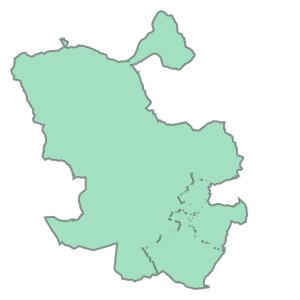